# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How many crimes were reported over the past 5 years?
- List the top five reported crimes for each year for the past 5 years.
- What are the most common MO codes? Have these changed over the past 5 years?
- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [13]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [14]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [15]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [16]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [17]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [18]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,0,0
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,int64,int64


## How many crimes were reported over the past 5 years?

In [19]:
# Check how many crimes were reported over the past 5 years
# Calculate current date and offset by 5 years
total_reported = (df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))).sum()
print(f'A: {total_reported} crimes were reported in the past 5 years.')

A: 1116665 crimes were reported in the past 5 years.


## List the top five reported crimes for each year for the past 5 years.

### Subset data for the last 5 years

In [20]:
# Select the last 5 years as a dataframe
df_5 = df[df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))]

In [21]:
# Find the top 5 reported crimes for each year
# Crime is listed in the data under 'crm_cd'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_crimes = gt.top_trends(df_5, column='year', variable='crm_cd', n=5)

In [22]:
# Add in the name of the crimes to dataframe
top_crimes["crm_name"] = convert.get_names(top_crimes, "crm_cd", crime_dict)

In [23]:
# create a rank column
top_crimes["rank"] = top_crimes.groupby('year')["count"].rank(ascending=False)

In [24]:
last_points = pd.DataFrame(top_crimes.groupby("crm_cd").tail(1)).reset_index()

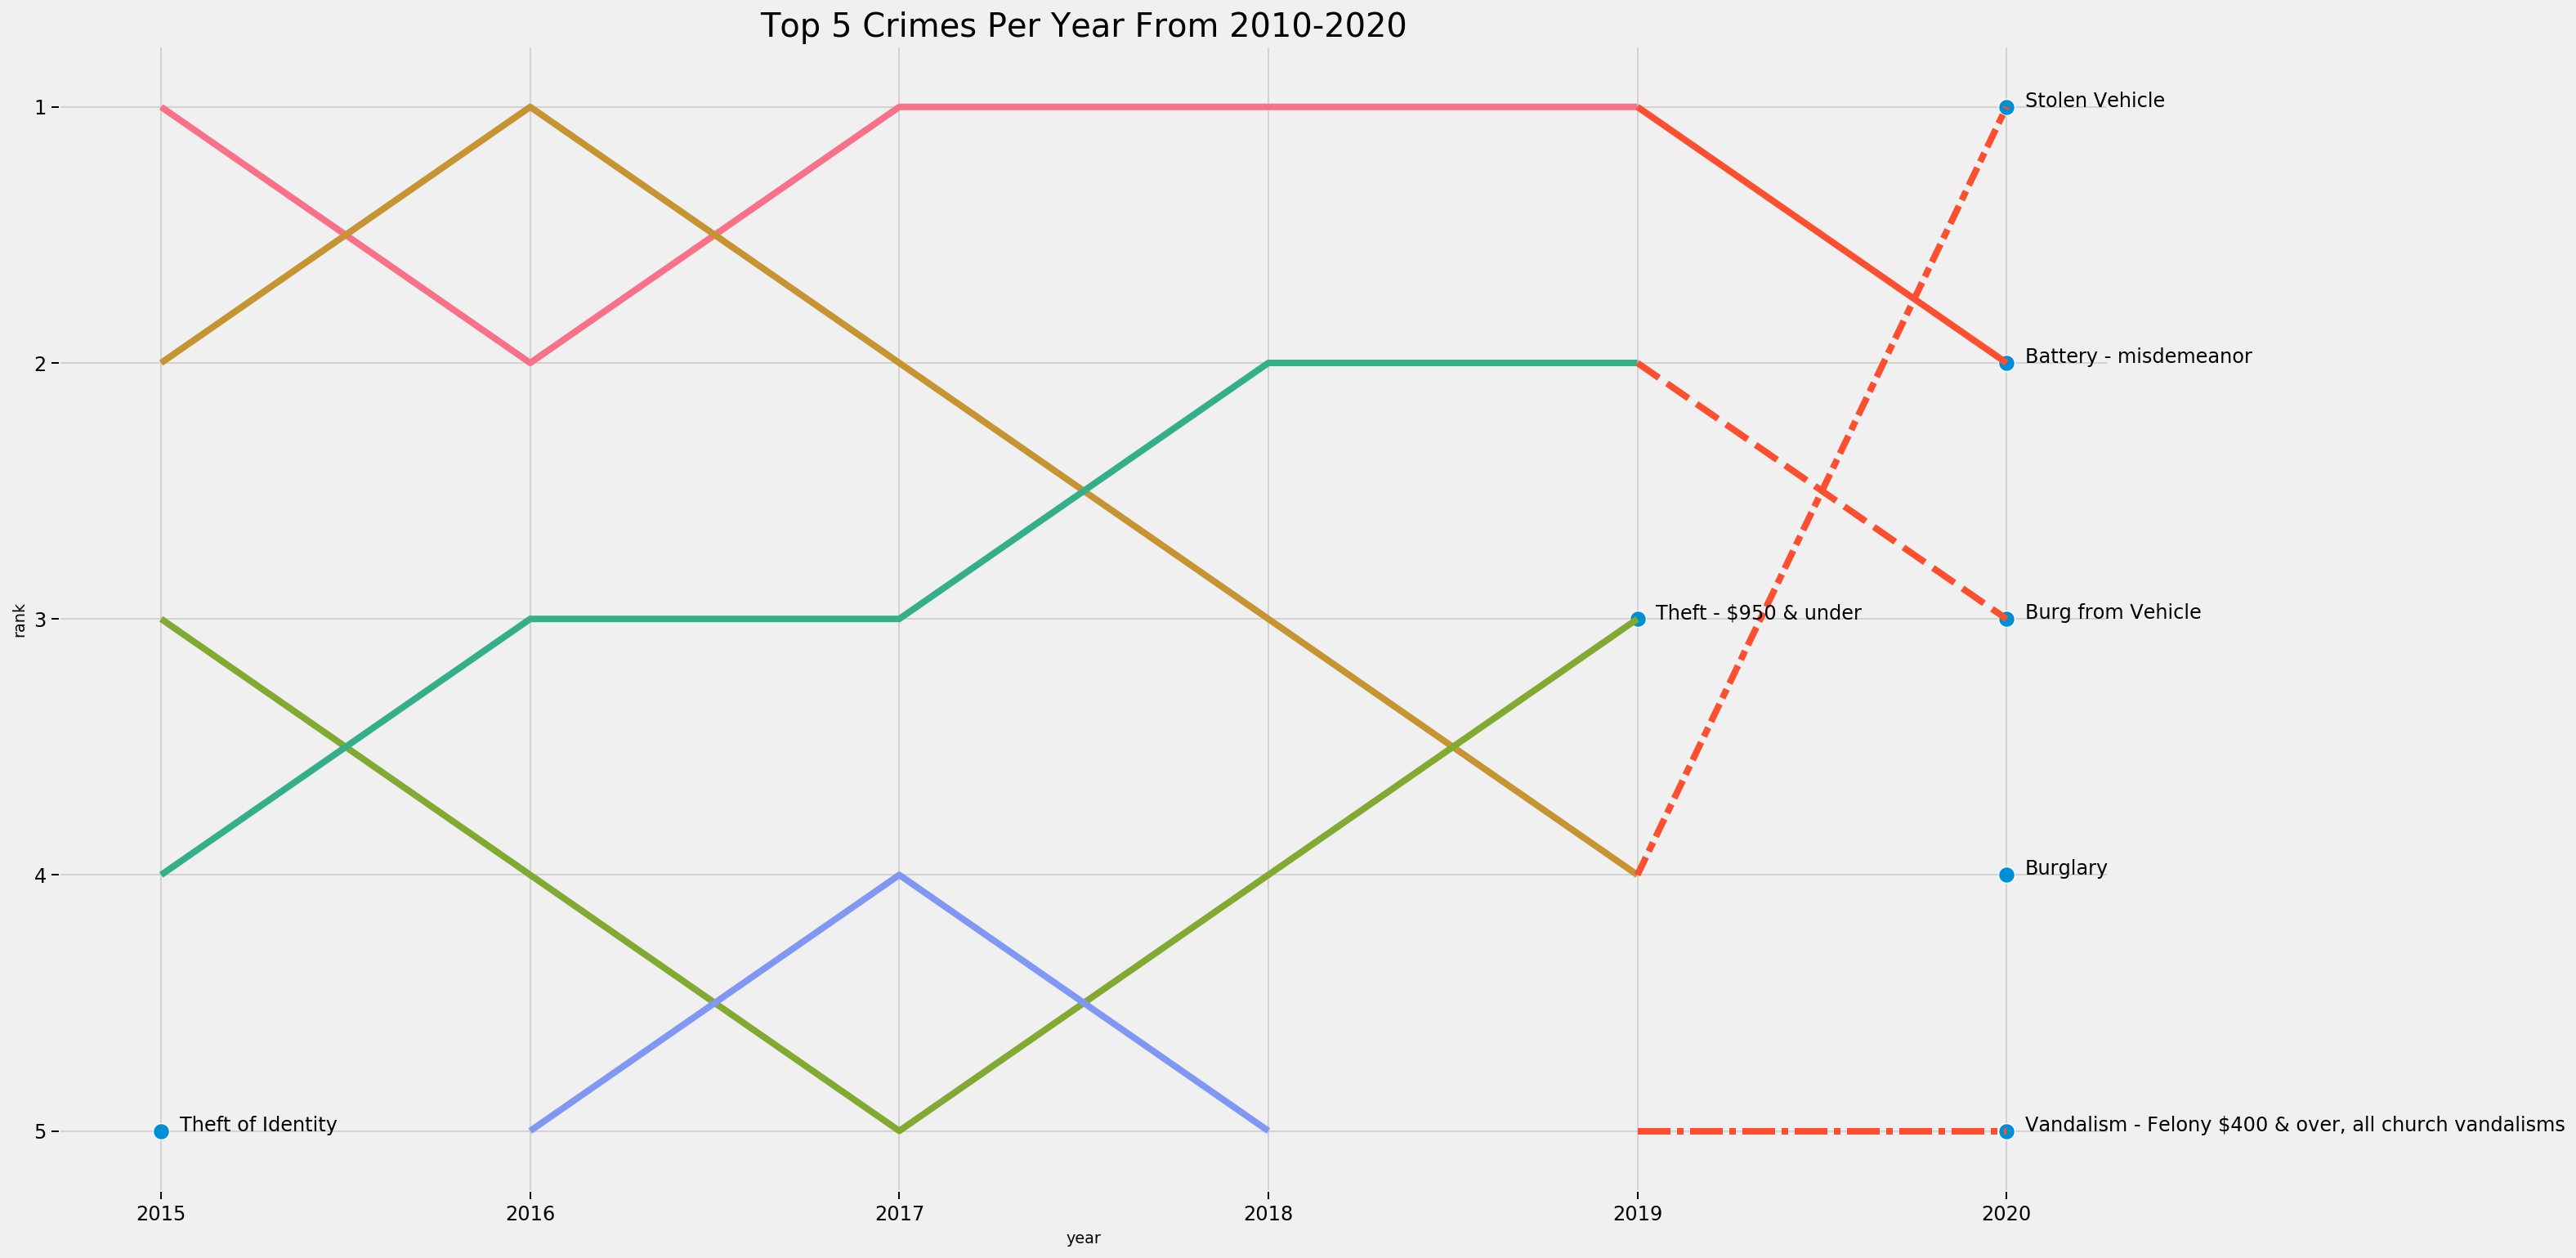

In [31]:
plt.figure(figsize=(20,12))

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc) 


ax = sns.lineplot(x="year", y="rank", hue="crm_name",markers = False,
                  data=top_crimes[top_crimes["year"]<=2019], legend = False, palette = sns.color_palette("husl", 7))
ax = sns.lineplot(x="year", y="rank", style="crm_name",markers = False,
                  data=top_crimes[top_crimes["year"]>=2019], legend = False, dashes = True)

ax = sns.scatterplot(x="year", y="rank", data=last_points, 
                     legend=False)


for i in range(0,last_points.shape[0]):
    ax.text(last_points["year"][i]+0.05, last_points["rank"][i],
           last_points["crm_name"][i], horizontalalignment='left', size =12)
    
plt.ylim(reversed(plt.ylim()))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks([5,4,3,2,1], size=12);
plt.title("Top 5 Crimes Per Year From 2010-2020", fontsize=20)
plt.savefig('../plots/top_crimes.eps', format='eps', dpi=72)

## What are the most common MO codes? Have these changed over the past 5 years?

From the summary info above, I see there are 240361 rows of missing MO codes in the original dataframe. I will remove the NA for this question.

In [34]:
# Select the last 5 years as a dataframe
df_5 = df_5[df_5["mocodes"].notnull()]

In [39]:
# Add in the name of the MO codes to dataframe
df_5["mo_name"] = convert.get_names(df_5, "mocodes_1", mocode_dict)

In [40]:
# Find the top 10 most common MO codes across all the years (2010-2020)
df_5["mo_name"].value_counts(ascending = False).head(10)

Removes vict property          220626
Vandalized                     93420 
Domestic violence              54050 
Hit-Hit w/ weapon              48468 
Stranger                       41127 
Force used                     30241 
Took merchandise               26056 
Other MO (see rpt)             23937 
Vehicle involved               20470 
Evidence Booked (any crime)    19203 
Name: mo_name, dtype: int64

In [45]:
# Find the top 10 MO codes for each year
# MO code is listed in the data under 'mocodes'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_mo = gt.top_trends(df_5, column='year', variable='mo_name', n=10)

In [46]:
# create a rank column
top_mo["rank"] = top_mo.groupby('year')["count"].rank(ascending=False)

In [47]:
top_mo.head()

,year,mo_name,count,rank
0,2015,Removes vict property,24598,1.0
1,2015,Vandalized,9183,2.0
2,2015,Domestic violence,5542,3.0
3,2015,Hit-Hit w/ weapon,5094,4.0
4,2015,Took merchandise,2795,5.0


In [50]:
last_points_mo = pd.DataFrame(top_mo.groupby("mo_name").tail(1)).reset_index()

In [52]:
palette = sns.color_palette("husl", top_mo["mo_name"].unique().shape[0])

Text(0.5, 1.0, 'Top 10 MO Codes Per Year')

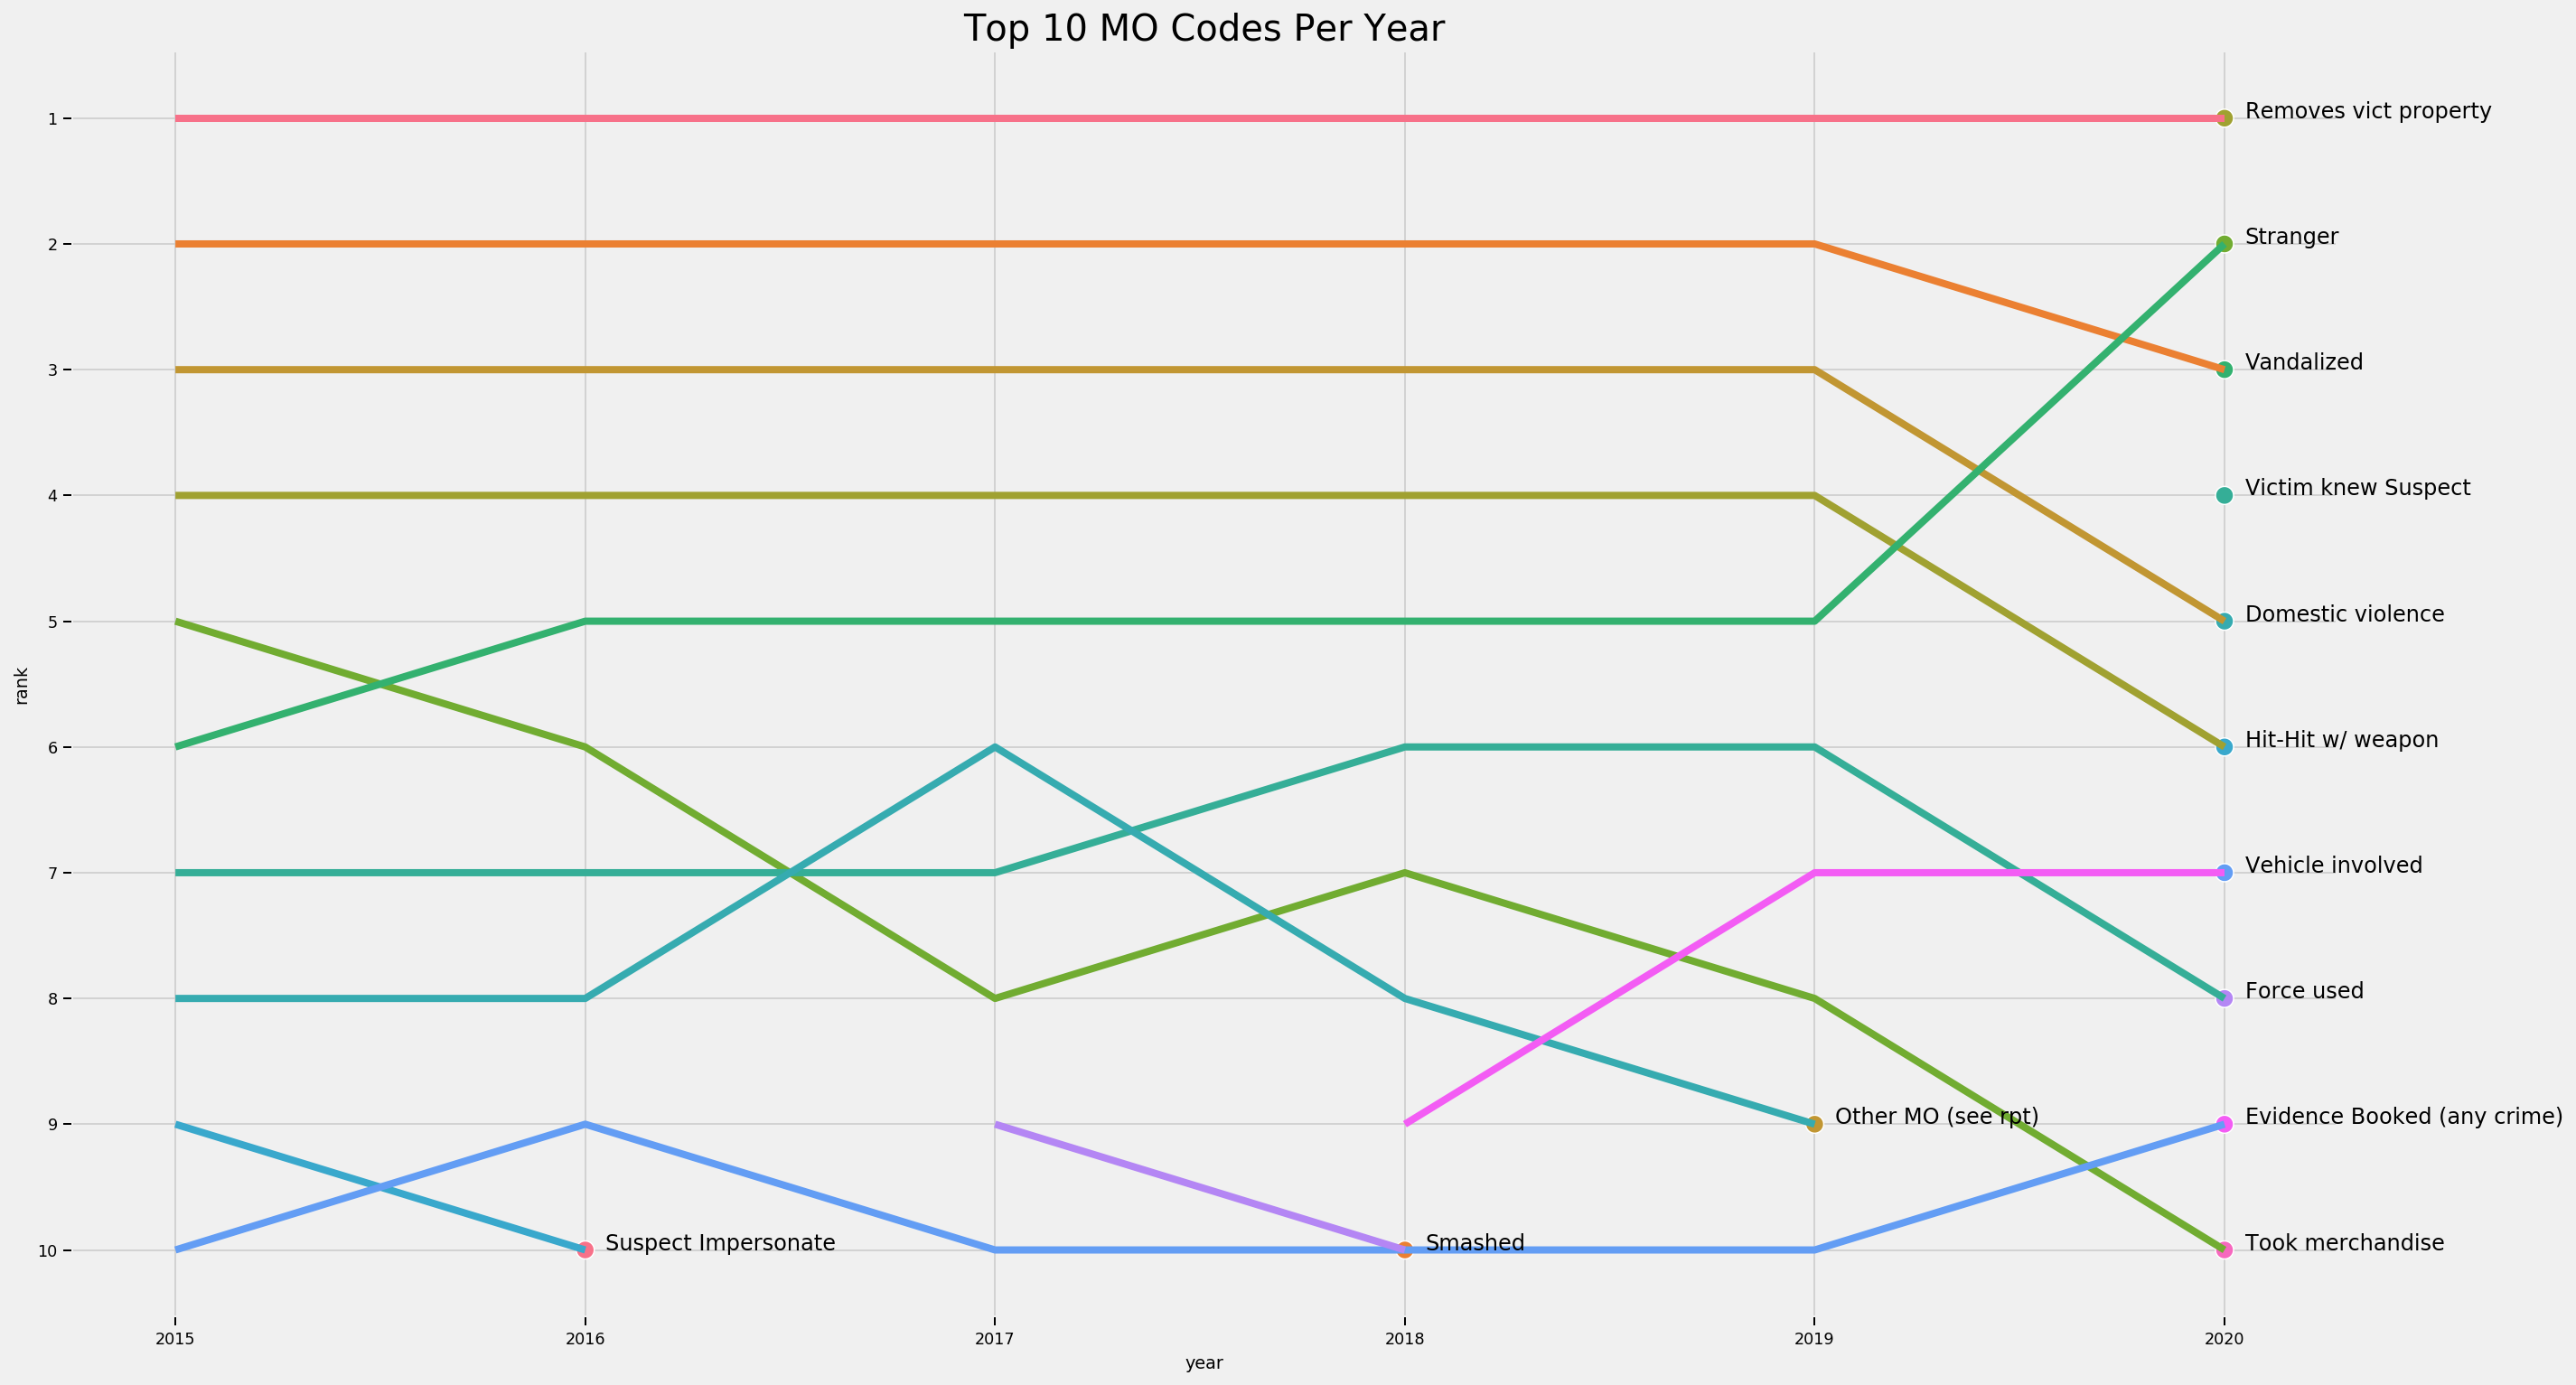

In [58]:
plt.figure(figsize=(20,12))

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc) 


ax = sns.lineplot(x="year", y="rank", hue="mo_name",markers = False,
                  data=top_mo, legend = False, palette = palette)
#ax = sns.lineplot(x="year", y="rank", style="mo_name",markers = False,
    #             data=top_mo[top_mo["year"]>=2019], legend = False, dashes = True)


ax = sns.scatterplot(x="year", y="rank", data=last_points_mo, 
        legend=False, hue="mo_name")


for i in range(0,last_points_mo.shape[0]):
     ax.text(last_points_mo["year"][i]+0.05, last_points_mo["rank"][i],
             last_points_mo["mo_name"][i], horizontalalignment='left', size =12)
    
plt.ylim(reversed(plt.ylim()))
plt.yticks([10,9,8,7,6,5,4,3,2,1]);
plt.title("Top 10 MO Codes Per Year 2010 to 2020", fontsize=20)